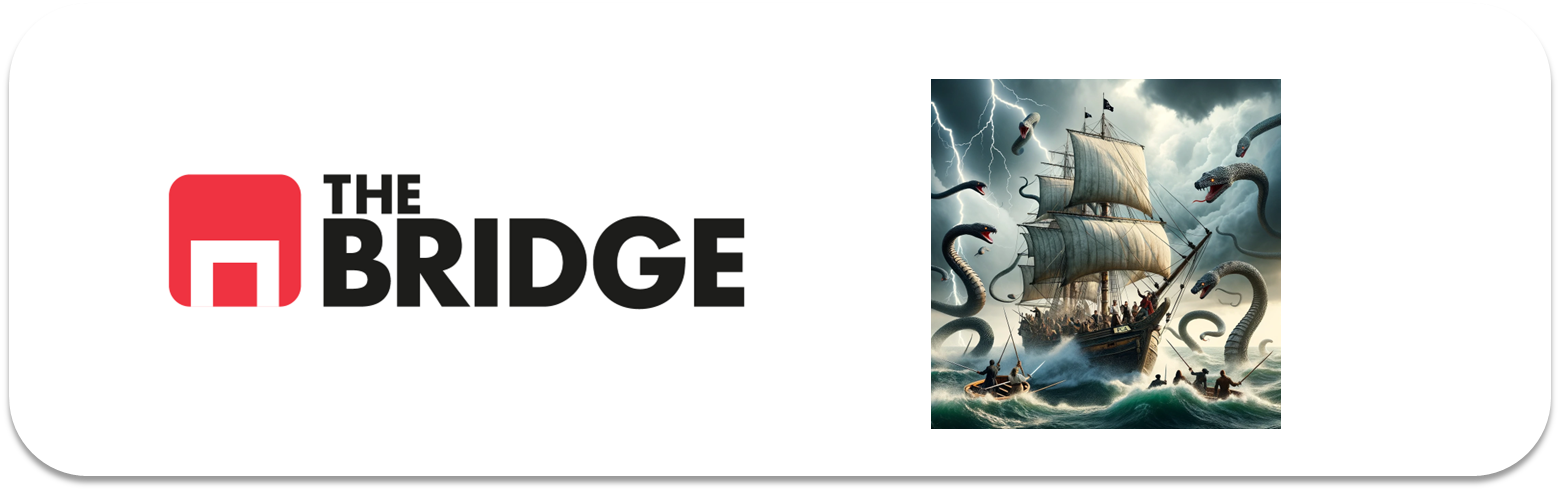

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [17]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

seed = 22

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [18]:
# Cargar el dataset de credit scoring
data = pd.read_csv('./data/credit_npo.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [19]:
# 1. Preprocesamiento del Dataset
# Eliminar filas con valores nulos
data = data.dropna()

# Convertir variables NumberOf... a categóricas (2 o 3 niveles)
categorical_columns = [
    'NumberOfTime30-59DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate', 
    'NumberOfTime60-89DaysPastDueNotWorse'
]

for col in categorical_columns:
    if col in data.columns:  # Asegurarse de que la columna existe
        data[col] = pd.cut(data[col], bins=3, labels=False)

# Separar características y variable objetivo
X = data.drop(columns=['SeriousDlqin2yrs'])
y = data['SeriousDlqin2yrs']

In [20]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convertir columnas categóricas a tipo 'category'
for col in categorical_columns:
    if col in X_train.columns:  # Asegurarse de que la columna existe
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

In [21]:
# Codificar columnas categóricas usando OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='category'))
X_test_encoded = encoder.transform(X_test.select_dtypes(include='category'))

# Combinar características numéricas y categóricas codificadas
X_train_final = np.hstack([X_train.select_dtypes(include='number').values, X_train_encoded])
X_test_final = np.hstack([X_test.select_dtypes(include='number').values, X_test_encoded])

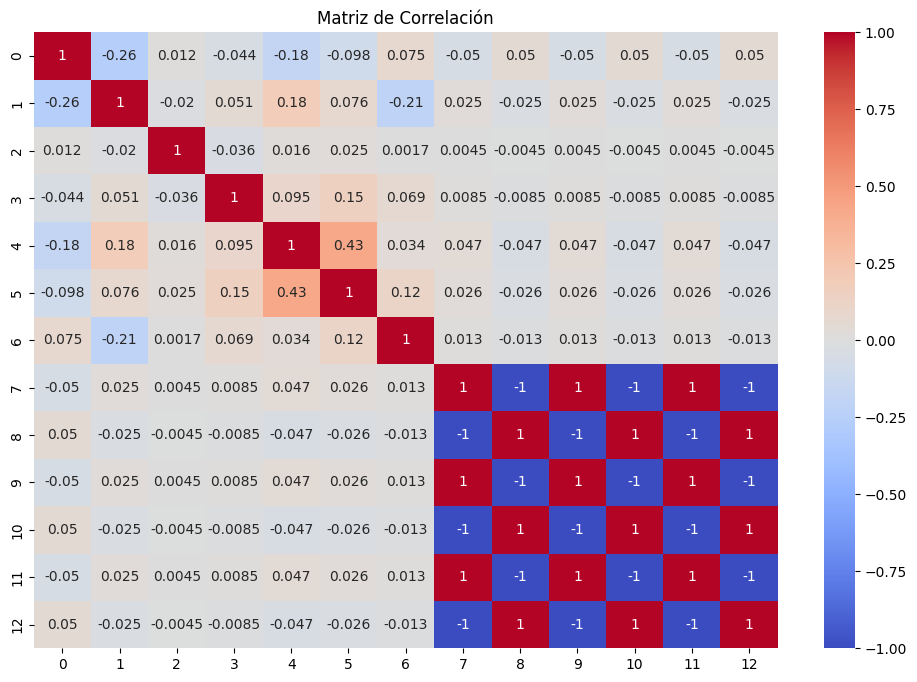

In [22]:
# 2. Selección de Características

# 2.1. Análisis visual combinado con correlación y covarianza
corr_matrix = pd.DataFrame(X_train_final).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Filtrar variables con alta correlación (>0.7)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

selected_features_1 = [i for i in range(X_train_final.shape[1]) if i not in high_corr_features]

In [23]:
# 2.2. Selección mediante SelectKBest y ANOVA
selector_anova = SelectKBest(f_classif, k=6)
X_train_anova = selector_anova.fit_transform(X_train_final, y_train)
selected_features_2 = selector_anova.get_support(indices=True)

In [24]:
# 2.3. Selección mediante Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k=6)
X_train_mi = selector_mi.fit_transform(X_train_final, y_train)
selected_features_3 = selector_mi.get_support(indices=True)

In [25]:
# 2.4. Selección mediante SelectFromModel
model_sfm = RandomForestClassifier(random_state=seed)
selector_sfm = SelectFromModel(model_sfm, max_features=6)
selector_sfm.fit(X_train_final, y_train)
selected_features_4 = selector_sfm.get_support(indices=True)

In [26]:
# 2.5. Selección mediante RFE
model_rfe = LogisticRegression(max_iter=5000)
rfe = RFE(model_rfe, n_features_to_select=6)
rfe.fit(X_train_final, y_train)
selected_features_5 = rfe.get_support(indices=True)

In [27]:
# 2.6. Selección mediante SFS
model_sfs = DecisionTreeClassifier(random_state=seed)
sfs = SFS(model_sfs, scoring='recall', cv=5)
sfs.fit(X_train_final, y_train)
selected_features_6 = list(sfs.get_support(indices=True))

In [28]:
# 2.7. Hard-Voting entre todas las técnicas
all_selected_features = [
    set(selected_features_1),
    set(selected_features_2),
    set(selected_features_3),
    set(selected_features_4),
    set(selected_features_5),
    set(selected_features_6)
]

voted_features = set.intersection(*all_selected_features)

In [29]:
# 3. Comparación de Modelos y Selección de Features
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

feature_lists = [
    selected_features_1,
    selected_features_2,
    selected_features_3,
    selected_features_4,
    selected_features_5,
    selected_features_6
]

results = []

for model_name, model in models.items():
    for i, feature_list in enumerate(feature_lists):
        X_train_cv = X_train_final[:, feature_list]
        scores = cross_val_score(model, X_train_cv, y_train, cv=5, scoring='recall')
        results.append((model_name, i+1, np.mean(scores)))

# Mostrar resultados
results_df = pd.DataFrame(results, columns=['Model', 'Feature List', 'Recall'])
print(results_df.sort_values(by='Recall', ascending=False))

                  Model  Feature List    Recall
6         Decision Tree             1  0.225963
9         Decision Tree             4  0.216673
11        Decision Tree             6  0.210495
8         Decision Tree             3  0.188885
7         Decision Tree             2  0.142433
16        Random Forest             5  0.136267
10        Decision Tree             5  0.133166
14        Random Forest             3  0.111437
13        Random Forest             2  0.100632
17        Random Forest             6  0.065021
15        Random Forest             4  0.057293
12        Random Forest             1  0.034061
4   Logistic Regression             5  0.018581
1   Logistic Regression             2  0.015480
5   Logistic Regression             6  0.015480
2   Logistic Regression             3  0.015480
3   Logistic Regression             4  0.013930
0   Logistic Regression             1  0.012379


In [30]:
# 4. Optimización de Hiperparámetros y Evaluación Final
best_model = 'Decision Tree'  # Mejor modelo según resultados
best_feature_list = selected_features_6  # Lista de características seleccionadas por SFS o hard-voting

# Definir el espacio de búsqueda de hiperparámetros para Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterio de división
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Mínimo número de muestras requeridas en un nodo hoja
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_final[:, best_feature_list], y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=22),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [31]:
# Evaluar contra test
best_model_final = grid_search.best_estimator_
y_pred = best_model_final.predict(X_test_final[:, best_feature_list])
final_recall = recall_score(y_test, y_pred)
print("Recall en Test:", final_recall)

Recall en Test: 0.21739130434782608


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

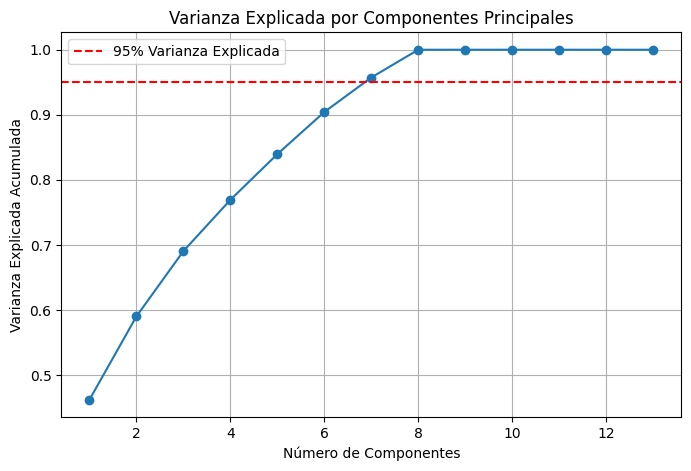

Número de componentes seleccionados: 7
Recall en Test con PCA: 0.20108695652173914


In [32]:
# Importar bibliotecas necesarias
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 1. Aplicar PCA: Escoger número de componentes en función de la varianza explicada
pca = PCA(random_state=seed)
X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train_final))

# Calcular la varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza Explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.legend()
plt.grid()
plt.show()

# Escoger el número de componentes que expliquen al menos el 95% de la varianza
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_components}")

# 2. Crear un dataset transformado usando PCA con el número de componentes seleccionados
pca = PCA(n_components=n_components, random_state=seed)
X_train_pca_reduced = pca.fit_transform(StandardScaler().fit_transform(X_train_final))
X_test_pca_reduced = pca.transform(StandardScaler().fit_transform(X_test_final))

# 3. Entrenar el mismo tipo de modelo ganador (Decision Tree)
best_model_pca = DecisionTreeClassifier(random_state=seed)

# Definir pipeline para estandarización y PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components, random_state=seed)),
    ('model', best_model_pca)
])

# Entrenar el modelo
pipeline.fit(X_train_final, y_train)

# Evaluar contra test
y_pred_pca = pipeline.predict(X_test_final)
recall_pca = recall_score(y_test, y_pred_pca)
print(f"Recall en Test con PCA: {recall_pca}")